# Submission

In [2]:
# Magic to automatically update imports if functions in utils are changed
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

In [3]:
from sklearn.model_selection import train_test_split

stores_train = pd.read_csv("data/stores_train.csv")
stores_test = pd.read_csv("data/stores_test.csv")
stores_extra = pd.read_csv("data/stores_extra.csv")

In [4]:
from utils import split_plaace_cat


store_dataframes = {
    "train": stores_train, 
    "extra": stores_extra, 
    "test": stores_test, 
    }

for df_name, df in store_dataframes.items():
    df = split_plaace_cat(df)

In [5]:
store_dataframes["train"]["log_revenue"] = store_dataframes["train"].revenue.apply(lambda x: np.log1p(x))

In [6]:
from utils import mean_rev_of_competitor, log_mean_rev_of_competitor, create_geographical_columns, create_chain_and_mall_columns, generate_chain_rev_dict, generate_plaace_rev_dict, create_mean_chain_rev_col

chain_count = stores_train["chain_name"].value_counts().to_dict()

for df_name, df in tqdm(store_dataframes.items()):
    store_dataframes[df_name] = create_geographical_columns(df)
    store_dataframes[df_name] = create_chain_and_mall_columns(df, chain_count, lower_limit=1)

chain_rev_dict, log_bounded_chain_rev_dict = generate_chain_rev_dict(store_dataframes["train"], quantile=0)

for i in tqdm(range(1, 5)):
    rev_plaace_dict, mean_plaace_revenue, log_rev_plaace_dict, log_mean_plaace_revenue = generate_plaace_rev_dict(store_dataframes["train"], i, quantile=0)
    for df_name, df in store_dataframes.items():
            store_dataframes[df_name] = mean_rev_of_competitor(store_dataframes[df_name], i, rev_dict=rev_plaace_dict, mean_revenue=mean_plaace_revenue)
            store_dataframes[df_name] = log_mean_rev_of_competitor(store_dataframes[df_name], i, log_rev_dict=log_rev_plaace_dict, log_mean_revenue=log_mean_plaace_revenue)
    
for df_name, df in tqdm(store_dataframes.items()):
    store_dataframes[df_name] = create_mean_chain_rev_col(df, bounded_chain_revs=chain_rev_dict, log_bounded_chain_revs=log_bounded_chain_rev_dict)

100%|██████████| 3/3 [00:00<00:00, 181.77it/s]


In [7]:
from utils import concat_df_keep_unq_index
concat_df = concat_df_keep_unq_index(store_dataframes["train"], store_dataframes["extra"])
concat_df = concat_df_keep_unq_index(concat_df, store_dataframes["test"])

In [8]:
from utils import find_dist_to_nearest_comp

nearest_comp_plaace_cat_gran = [1, 2, 3, 4]
n_nearest_comp = [1, 2, 3, 4, 5, 7, 10]

store_dataframes["train"] = find_dist_to_nearest_comp(
    store_dataframes["train"], 
    nearest_comp_plaace_cat_gran, 
    n_nearest_comp, 
    training=True, 
    training_df=concat_df,
    )

In [9]:
store_dataframes["test"] = find_dist_to_nearest_comp(
    store_dataframes["test"], 
    nearest_comp_plaace_cat_gran, 
    n_nearest_comp, 
    training=True,
    training_df=concat_df
)

In [10]:
comp_plaace_cols = list(store_dataframes["train"].columns[-56:])

In [11]:
dist_dict = store_dataframes["train"][['log_revenue'] + comp_plaace_cols].corr().iloc[0].to_dict()
sorted_relevant_dist_cols = [[k, v] for k, v in sorted(dist_dict.items(), key=lambda item: abs(item[1]), reverse=True)]

In [12]:
comp_relevant_cols = sorted_relevant_dist_cols[1:14:2]
comp_relevant_cols = [r[0] for r in comp_relevant_cols]

In [13]:
new_comp_relevant_cols = [
    'sum_dist_to_nearest_10_comp_plaace_1',
    'sum_dist_to_nearest_3_comp_plaace_1',
    'sum_dist_to_nearest_1_comp_plaace_1', 
    'sum_dist_to_nearest_3_comp_plaace_2',
    'sum_dist_to_nearest_1_comp_plaace_2',
    'sum_dist_to_nearest_1_comp_plaace_3',
    ]

In [14]:
from bus_utils import find_closest_bus_stop

bus_stop_n = [1, 2, 3, 5, 7, 10, 15 ,25, 50, 100]
bus_mean = True
bus_sum = True

bus_stop_columns = []

if(bus_sum):
    bus_stop_columns += [f"closest_bus_stop_sum_{i}" for i in bus_stop_n]

if(bus_mean):
    bus_stop_columns += [f"closest_bus_stop_mean_{i}" for i in bus_stop_n]


for df_name, df in tqdm(store_dataframes.items()):
    store_dataframes[df_name] = find_closest_bus_stop(df, bus_stop_n, _sum=bus_sum, _mean=bus_mean)    

100%|██████████| 3/3 [12:03<00:00, 241.27s/it]


In [15]:
bus_dict = store_dataframes["train"][['log_revenue'] + bus_stop_columns].corr().iloc[0].to_dict()
bus_sorted_relevant_dist_cols = [[k, v] for k, v in sorted(bus_dict.items(), key=lambda item: abs(item[1]), reverse=True)]

In [16]:
bus_relevant_cols = bus_sorted_relevant_dist_cols[1::2]
bus_relevant_cols = [r[0] for r in bus_relevant_cols]

In [17]:
bus_relevant_cols = bus_relevant_cols[:5]

In [18]:
from grunnkrets_old import make_grunnkrets_df

full_population_dataframes = {}
full_pop_columns = []

for df_name, df in tqdm(store_dataframes.items()):
    full_population_dataframes[df_name] = make_grunnkrets_df(df)
    full_pop_columns = full_population_dataframes[df_name].columns

 33%|███▎      | 1/3 [00:07<00:14,  7.16s/it]/Users/oskarjor/NTNU/2022FALL/TDT4173/TDT4173/grunnkrets_old.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_population_df[f'{level}.income_density_log']  = np.log1p(full_population_df[f'{level}.income_density'])
/Users/oskarjor/NTNU/2022FALL/TDT4173/TDT4173/grunnkrets_old.py:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_population_df[f'{level}.income_density']  = full_population_df[f'{level}.total_income']/full_population_df[f'{level}.area_km2']
/Users/oskarjor/N

In [19]:
full_pop_columns = list(full_pop_columns[-184:])

In [20]:
for df_name, df in store_dataframes.items():
    store_dataframes[df_name] = df.merge(
        full_population_dataframes[df_name], 
        left_index=True,
        right_index=True,
        how="outer", 
        suffixes=('', '_redundant')
    )
    store_dataframes[df_name].drop(store_dataframes[df_name].filter(regex='_redundant$').columns, axis=1, inplace=True)

In [21]:
full_pop_dict = store_dataframes["train"][['log_revenue'] + full_pop_columns].corr().iloc[0].to_dict()
full_pop_sorted_relevant_dist_cols = [[k, v] for k, v in sorted(full_pop_dict.items(), key=lambda item: abs(item[1]), reverse=True)]

In [22]:
full_pop_relevant_cols = full_pop_sorted_relevant_dist_cols[1:8]
full_pop_relevant_cols = [r[0] for r in full_pop_relevant_cols]

In [23]:
fylke_relevant_features = [col_name for col_name in store_dataframes["train"].columns if col_name.startswith("fylke.")]
kommune_relevant_features = [col_name for col_name in store_dataframes["train"].columns if col_name.startswith("kommune.")]
delomrade_relevant_features = [col_name for col_name in store_dataframes["train"].columns if col_name.startswith("delomrade.")]
grunnkrets_relevant_features = [col_name for col_name in store_dataframes["train"].columns if col_name.startswith("grunnkrets_id.")]

In [24]:
from num_stores import add_num_stores_info

for df_name, df in store_dataframes.items():
    store_dataframes[df_name] = add_num_stores_info(df)

/Users/oskarjor/NTNU/2022FALL/TDT4173/TDT4173/num_stores.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = geo_df.groupby([ level , cat]).sum()['count'].to_frame()
/Users/oskarjor/NTNU/2022FALL/TDT4173/TDT4173/num_stores.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = geo_df.groupby([ level , cat]).sum()['count'].to_frame()
/Users/oskarjor/NTNU/2022FALL/TDT4173/TDT4173/num_stores.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns wh

In [25]:
num_store_cols = list(store_dataframes["train"].columns[-64:])

In [26]:
num_store_dict = store_dataframes["train"][['log_revenue'] + num_store_cols].corr().iloc[0].to_dict()
num_store_sorted_relevant_cols = [[k, v] for k, v in sorted(num_store_dict.items(), key=lambda item: abs(item[1]), reverse=True)]

In [27]:
num_store_relevant_cols = num_store_sorted_relevant_cols[1:15]
num_store_relevant_cols = [r[0] for r in num_store_relevant_cols]

## Adding mean revenue (plaace_cat, level)

In [28]:
from avg_revenue import add_avg_revenue, create_avg_revenue_csvs

create_avg_revenue_csvs()

for df_name, df in store_dataframes.items():
    store_dataframes[df_name] = add_avg_revenue(df, total=True)

In [29]:
mean_rev_cols = list(store_dataframes["train"].columns)[-20:]

In [30]:
mean_rev_dict = store_dataframes["train"][['log_revenue'] + mean_rev_cols].corr().iloc[0].to_dict()
mean_rev_sorted_relevant_cols = [[k, v] for k, v in sorted(mean_rev_dict.items(), key=lambda item: abs(item[1]), reverse=True)]

In [31]:
mean_rev_relevant_cols = mean_rev_sorted_relevant_cols[1:]
mean_rev_relevant_cols = [r[0] for r in mean_rev_relevant_cols]

In [32]:
mean_rev_relevant_log_cols = []
for col in mean_rev_relevant_cols:
    for df_name, df in store_dataframes.items():
        store_dataframes[df_name][col + "_log"] = store_dataframes[df_name][col].apply(lambda x: np.log1p(x))
    mean_rev_relevant_log_cols.append(col + "_log")

In [33]:
from new_plaace_index import create_index_csv, add_new_plaace_index

create_index_csv()

for df_name, df in store_dataframes.items():
    store_dataframes[df_name] = add_new_plaace_index(store_dataframes[df_name])

In [34]:
from clustering import add_clusters, create_cluster_csv

create_cluster_csv()

for df_name, df in store_dataframes.items():
    store_dataframes[df_name] = add_clusters(store_dataframes[df_name])

/Users/oskarjor/NTNU/2022FALL/TDT4173/TDT4173/clustering.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  geo_df = stores_total_train.append(stores_extra).append(stores_test)[['lat', 'lon', 'store_id']]


In [35]:
for df_name, df in store_dataframes.items():
    store_dataframes[df_name]["chain_count"] = store_dataframes[df_name].bounded_chain_name.apply(lambda x: 0 if (x == "OTHER" or x in chain_count.keys()) else chain_count[x])

# Transforming the data

In [36]:
from RMSLE import rmsle
from pred_var_utils import reverse_log1p_transform_pred_var
from sklearn.model_selection import GridSearchCV

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


OE_categorical_features = ["bounded_chain_name", "kommune", "delomrade", "is_grocery", "plaace_cat_2", "plaace_cat_3", "plaace_cat_4", ]#"new_plaace"]
OE_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="constant")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ]
)

OH_categorical_features = ["plaace_cat_1"] #["fylke", "plaace_cat_2"]
OH_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="constant")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)


numerical_features = ["lat", "lon", 
#"mean_revenue_1", "mean_revenue_2", "mean_revenue_3", "mean_revenue_4", 
"log_mean_revenue_1", "log_mean_revenue_2", "log_mean_revenue_3", "log_mean_revenue_4", 
"fylke.plaace_cat_1_mean_revenue_log", #"fylke.plaace_cat_3_mean_revenue_log", 
"log_chain_mean_revenue"
] + full_pop_relevant_cols + comp_relevant_cols + bus_relevant_cols + num_store_relevant_cols #+ mean_rev_relevant_log_cols
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")), 
        ("scaler", StandardScaler(with_mean=True, with_std=True))]
)


preprocessor = ColumnTransformer(
   transformers=[
       ("oe_cat", OE_categorical_transformer, OE_categorical_features),
       ("oh_cat", OH_categorical_transformer, OH_categorical_features),
       ("num", numerical_transformer, numerical_features),
   ],
   remainder='drop'
)


X_train = preprocessor.fit_transform(store_dataframes["train"])

In [38]:
y_train = np.array(store_dataframes["train"].log_revenue)
mean_y = y_train.mean()
std_y = y_train.std()

y_train -= mean_y
y_train /= std_y

# Training the model

## CatBoost

In [39]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

cb = CatBoostRegressor(
    random_seed=0, 
    verbose=False, 
    eval_metric="RMSE", 
    rsm=0.1,
    depth=6, 
    l2_leaf_reg= 10, 
    learning_rate= 0.05
    )

In [40]:
cb.fit(X_train, y_train)

In [72]:
feature_importance = list(zip(list(preprocessor.get_feature_names_out()), list(cb.get_feature_importance())))

In [74]:
sorted_feature_importance = sorted(feature_importance, key = lambda item: item[1], reverse=True)

In [76]:
sorted_feature_importance

[('num__log_chain_mean_revenue', 28.9369837957904),
 ('num__log_mean_revenue_4', 9.263677464217828),
 ('num__log_mean_revenue_3', 5.3082975494216065),
 ('oe_cat__bounded_chain_name', 4.737861860495183),
 ('num__log_mean_revenue_2', 1.7233626960437556),
 ('num__grunnkrets_id.pop_density', 1.7040928399853934),
 ('num__closest_bus_stop_mean_50', 1.690165088643237),
 ('num__delomrade.plaace_cat_1_count', 1.6495843119614078),
 ('num__grunnkrets_id.plaace_cat_1_count', 1.6333700431495328),
 ('num__sum_dist_to_nearest_5_comp_plaace_1', 1.5691607968053756),
 ('num__fylke.plaace_cat_4_per_tot_income', 1.5474619921423822),
 ('num__grunnkrets_id.income_density', 1.5167674555991437),
 ('num__sum_dist_to_nearest_4_comp_plaace_1', 1.4651135837882812),
 ('num__delomrade.c_age_56-90_ratio', 1.4408126660375107),
 ('num__closest_bus_stop_mean_25', 1.4197632269177654),
 ('num__fylke.plaace_cat_3_per_tot_income', 1.3959681602113998),
 ('num__closest_bus_stop_sum_10', 1.3914472259355788),
 ('num__grunnkret

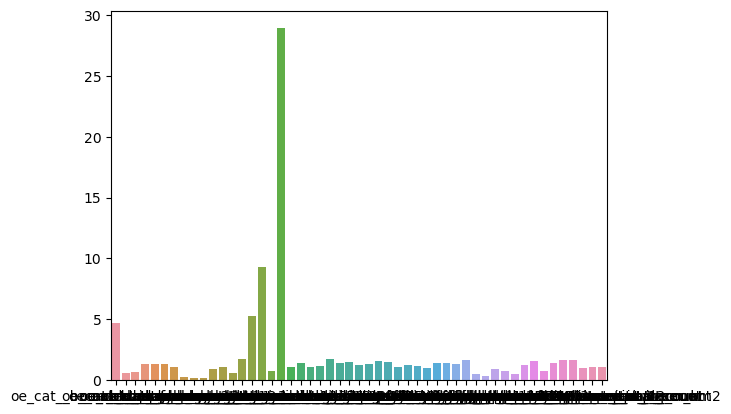

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.barplot(x=feature_names, y=feature_importance, label=feature_names)

# Creating the submission

In [ ]:
# Predict on the test set 
X_test = preprocessor.transform(store_dataframes["test"])
y_test_pred = reverse_log1p_transform_pred_var(cb.predict(X_test), std_y, mean_y)

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = stores_test.store_id 
submission['predicted'] = np.asarray(y_test_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission.csv', index=False)